In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_year = ["Datasets/TS Rainfall data January 2022.csv", "Datasets/TS Rainfall data February 2022.csv", "Datasets/TS Rainfall data March 2022.csv", \
             "Datasets/TS Rainfall data April 2022.csv", "Datasets/TS Rainfall data May 2022.csv", "Datasets/TS Rainfall data June 2022.csv", \
             "Datasets/TS Rainfall data July 2022.csv", "Datasets/TS Rainfall data August 2022.csv", "Datasets/TS Rainfall data Septmeber 2022.csv", \
             "Datasets/TS Rainfall data October 2022.csv", "Datasets/TS Rainfall data November 2022.csv", "Datasets/TS Rainfall data December 2022.csv", \
             "Datasets/TS Rainfall data January 2023_0.csv"]

In [3]:
df = pd.DataFrame()
for d in data_year:
    data = pd.read_csv(d)
    data = data[(data["District"] == "Hyderabad") & (data["Mandal"] == "Secunderabad")]
    df = pd.concat([df,data], axis = 0, ignore_index=True)

In [4]:
# Drop Columns
df = df.drop(["District", "Mandal"], axis = 1)

# Set Date as Index
from datetime import datetime, date
df["Date"] = pd.to_datetime(df['Date'], format = '%d-%b-%y')

date_df = pd.DataFrame()
date_df["Date"] = pd.date_range(start="2022-01-01", end="2023-01-31")

df = pd.merge(df,date_df, on="Date", how = "right")
df = df.set_index("Date")
df = df.sort_index(ascending=True)

In [5]:
print("Shape :", df.shape)
df.head()

Shape : (396, 3)


,Rain (mm),Min Humidity (%),Max Humidity (%)
Date,,,
2022-01-01,0.0,50.1,83.6
2022-01-02,0.0,53.5,88.6
2022-01-03,0.0,49.4,92.6
2022-01-04,0.0,46.5,80.8
2022-01-05,0.0,44.1,82.8


## Data visualization 📊

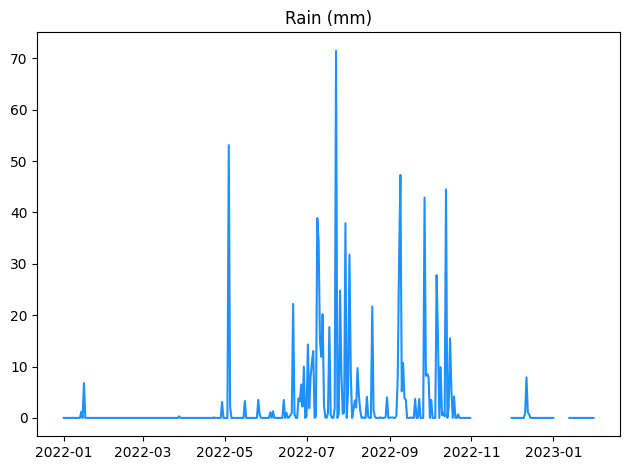

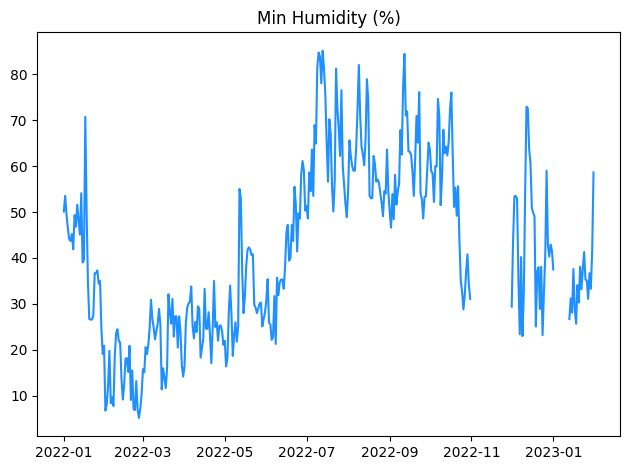

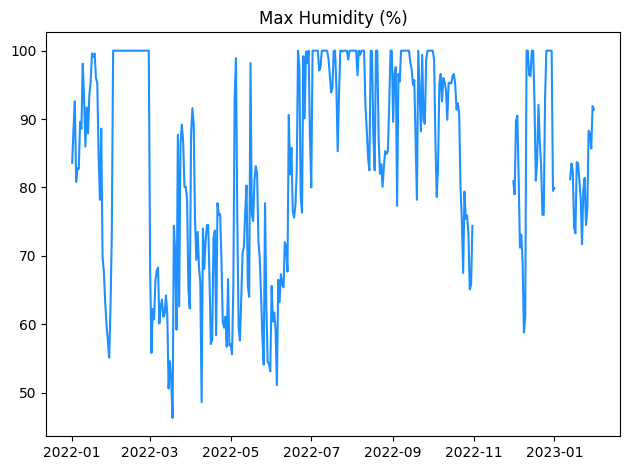

In [6]:
for i in df:
    plt.plot(df[i].fillna(np.inf), color='dodgerblue')
    plt.title(i)
    plt.tight_layout()
    plt.show()

## Data Preprocessing

### Handle Null Values

In [7]:
print("No of Null Values : ", df["Rain (mm)"].isnull().sum())

No of Null Values :  38


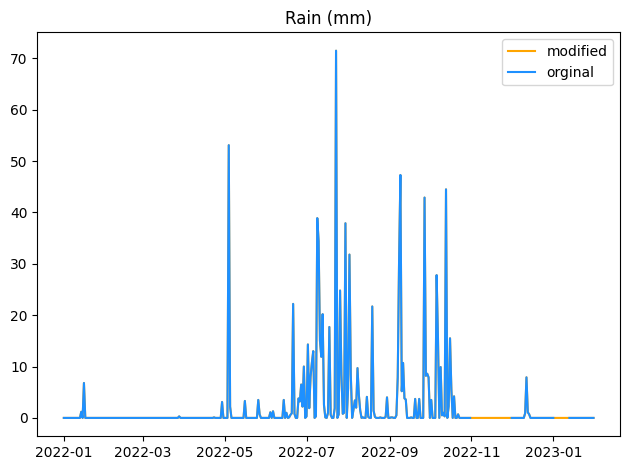

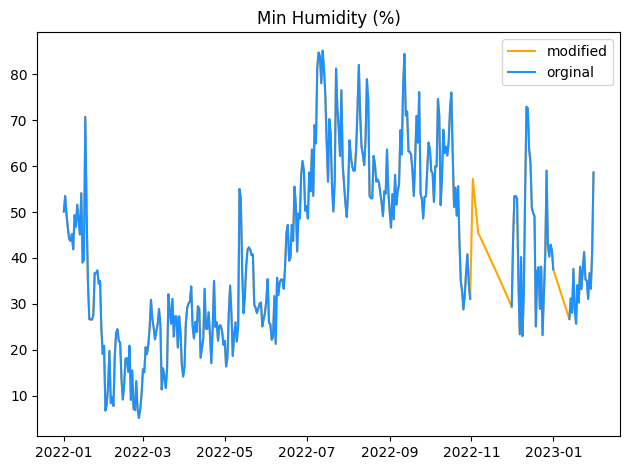

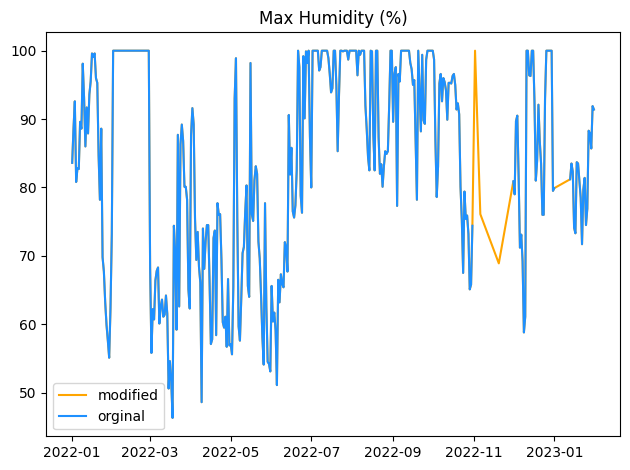

In [8]:
# Filling Null Values using interpolate
for i in df:
    # Plot
    plt.plot(df[i].interpolate(), color='orange', label="modified")
    plt.plot(df[i], color='dodgerblue', label="orginal")
    plt.title(i)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Fill Na
    df[i] = df[i].interpolate()

## Stationarity

### Rolling Statistics

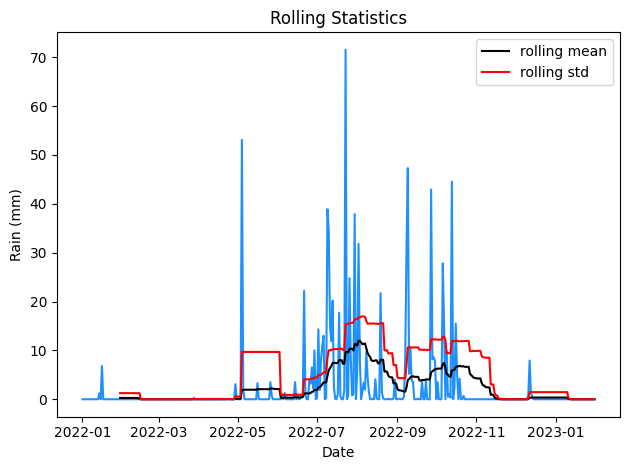

In [9]:
rolling_window = 30

sns.lineplot(df["Rain (mm)"], color='dodgerblue')
sns.lineplot(df["Rain (mm)"].rolling(rolling_window).mean(), color='black', label='rolling mean')
sns.lineplot(df["Rain (mm)"].rolling(rolling_window).std(), color='red', label='rolling std')
plt.title('Rolling Statistics')
plt.tight_layout()
plt.show()

##### From the above plot it is evident that the features don't have constant mean and std.

### Augmented Dickey-Fuller Test

In [10]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["Rain (mm)"],autolag='AIC')
result

(-3.898705607274293,
 0.0020443938021366985,
 9,
 386,
 {'1%': -3.447405233596701,
  '5%': -2.8690569369014605,
  '10%': -2.5707743450830893},
 2599.9760402230454)

##### From ADF Test it is evident that the data is stationary

### Differencing

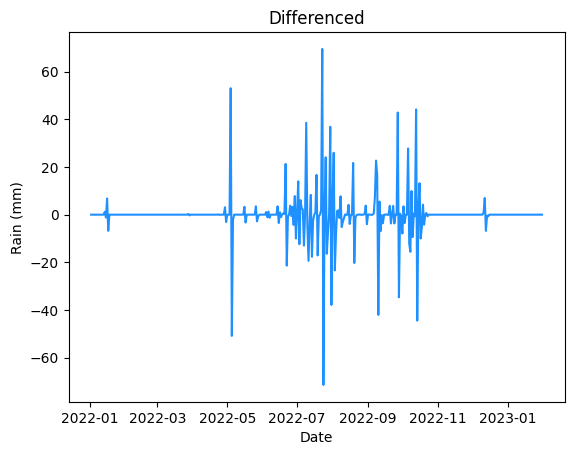

In [11]:
# Plot
sns.lineplot(df["Rain (mm)"].diff(), color="dodgerblue")
plt.title("Differenced")
plt.show()

diff = np.diff(df["Rain (mm)"])
df['Rain (mm) diff'] = np.append([0], diff)

## Seasonal Decompose

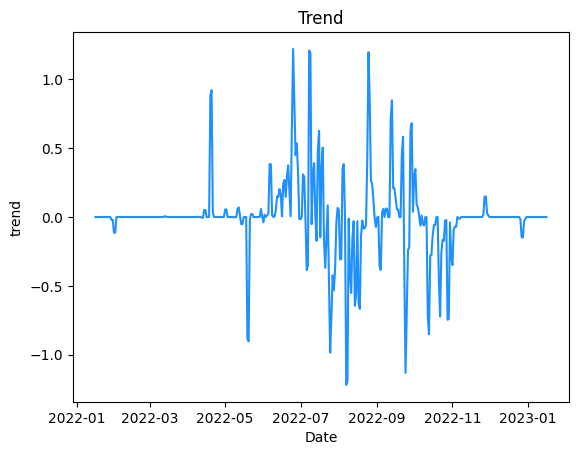

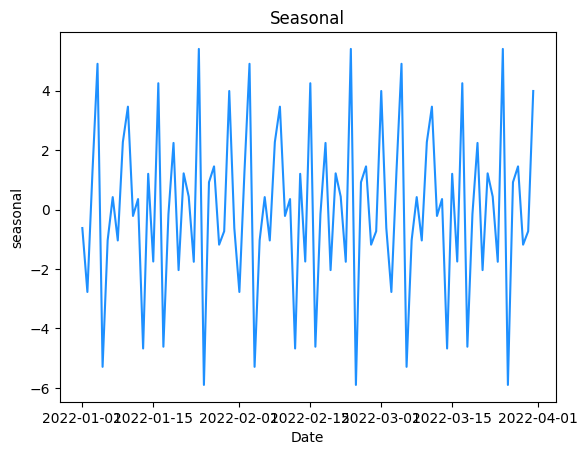

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["Rain (mm) diff"], period=30)
trend = decompose.trend
seasonal = decompose.seasonal

sns.lineplot(x=df.index, y=trend, color = "dodgerblue")
plt.title("Trend")
plt.show()

sns.lineplot(x=df.index[:90], y=seasonal[:90], color = "dodgerblue")
plt.title("Seasonal")
plt.show()

## Autocorrelation Analysis

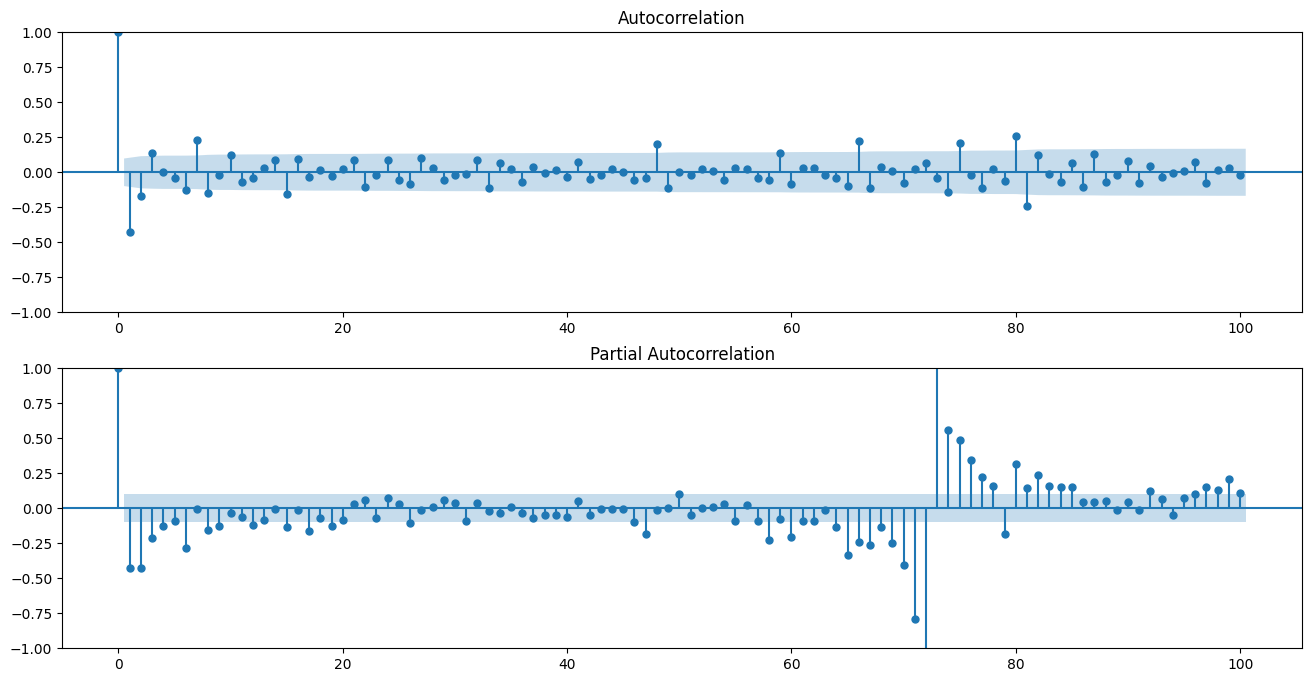

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['Rain (mm) diff'], lags=100, ax=ax[0])
plot_pacf(df['Rain (mm) diff'], lags=100, ax=ax[1])

plt.show()

## ARIMA Model

In [14]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df["Rain (mm)"].iloc[:-31].values, order=(1,1,1))
model_fit = model.fit()

y_pred = model_fit.forecast(31)

from sklearn.metrics import mean_absolute_error, mean_squared_error
print("MAE :", mean_absolute_error(y_pred, df["Rain (mm)"].iloc[-31:].values))
print("MSE :", mean_squared_error(y_pred, df["Rain (mm)"].iloc[-31:].values))
print("RMSE :", np.sqrt(mean_squared_error(y_pred, df["Rain (mm)"].iloc[-31:].values)))

MAE : 0.2364146957482664
MSE : 0.05590271935471013
RMSE : 0.23643755910326542


### Forecast

In [15]:
pred = pd.DataFrame()
pred["Date"] = pd.date_range(start="2023-01-01", end="2023-01-31")
pred["Rain (mm)"] = y_pred
pred = pred.set_index("Date")

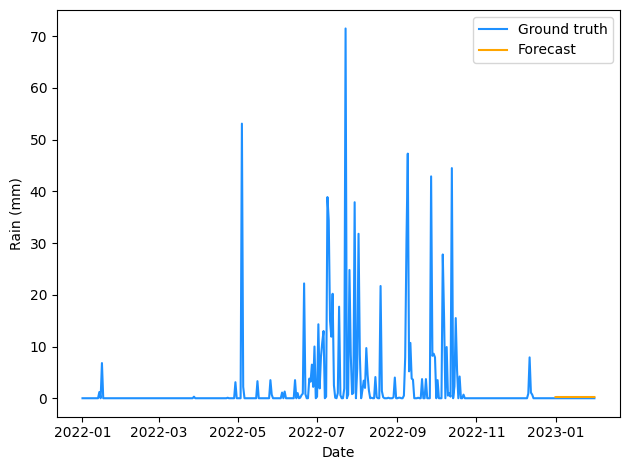

In [16]:
sns.lineplot(df["Rain (mm)"], color='dodgerblue', label="Ground truth")
sns.lineplot(pred["Rain (mm)"], color='orange', label="Forecast")
plt.tight_layout()
plt.show()

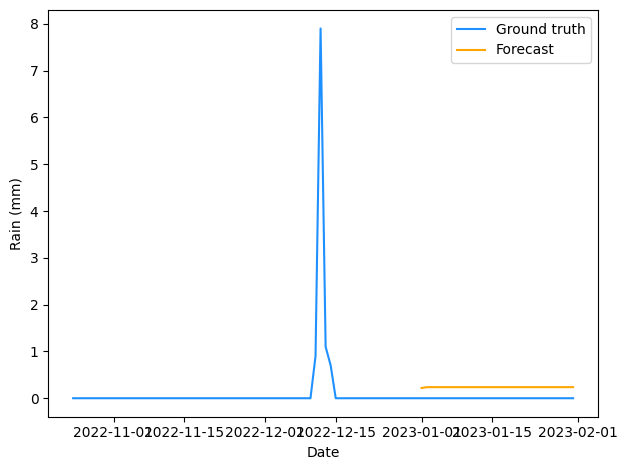

In [17]:
sns.lineplot(df["Rain (mm)"][-100:], color='dodgerblue', label="Ground truth")
sns.lineplot(pred["Rain (mm)"], color='orange', label="Forecast")
plt.tight_layout()
plt.show()